In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

# Take a look at data

In [4]:
file = '/Users/danichao/self_data/data_banknote_authentication.txt'
data = pd.read_csv(file, header=None, names=['variance', 'skewness', 'curtosis', 'entropy', 'class'])

In [5]:
data.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


# Explore the distributions of features (so we will know how to preprocess the data)

In [2]:
def FeatureDistribution(feature):
    fig = plt.figure(figsize=(8,4))
    sns.histplot(data.loc[:, feature], color='r', kde=True)
    plt.xlabel(feature)
    plt.ylabel('density')
    plt.legend()
    plt.show()

/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


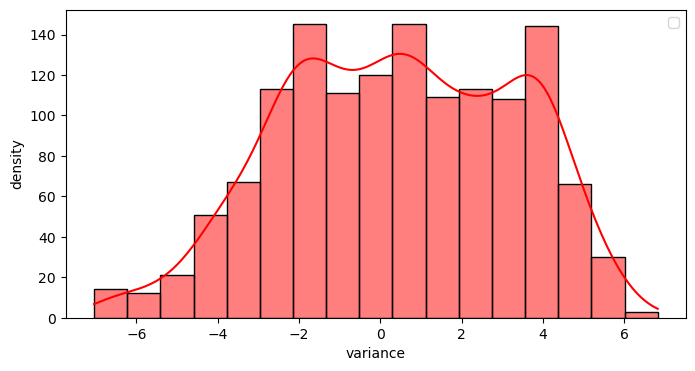

In [6]:
FeatureDistribution('variance')

Variance has Gaussian distribution. We should apply normalization to variance.

/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


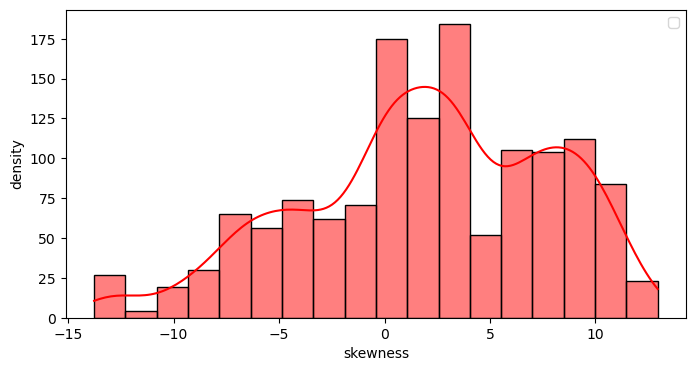

In [7]:
FeatureDistribution('skewness')

Skewness also has a Gaussian-like distribution. We will apply normalization to skewness as well.

/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


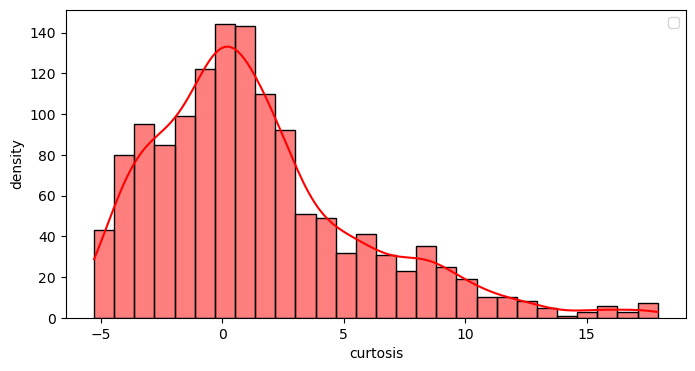

In [8]:
FeatureDistribution('curtosis')

Curtosis is not Gaussian distributed - it does not peak in the middle; it peak toward left. However, it is also not a perfect power-law distribution. Creating quantiles for curtosis is the only way.

/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


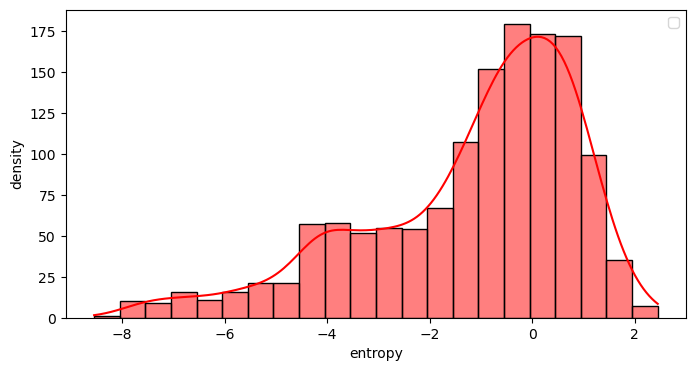

In [9]:
FeatureDistribution('entropy')

Similar to curtosis, entropy peak toward one end but is not a perfect power-law distribution. We will also have to create quantiles for curtosis as well.

# Preprocessing data: normalization & quantile scaling

In [10]:
def feature_normalization(feature):
    norm_feature = '{}_norm'.format(feature)
    data[norm_feature] = (data[feature] - data[feature].mean())/data[feature].std()

In [23]:
def feature_quan_scale(feature, numQuant):
    quant_feature = '{}_quant'.format(feature)
    scale_feature = '{}_scale'.format(feature)
    data[quant_feature] = pd.qcut(data[feature], numQuant, duplicates='drop', labels=False)
    data[scale_feature] = (data[quant_feature] - data[quant_feature].min()) / (data[quant_feature].max() - data[quant_feature].min())

In [24]:
normalization_features = ['variance', 'skewness']
quantile_features = ['curtosis', 'entropy']
num_quantiles = 10

for feature in normalization_features:
    feature_normalization(feature)

for feature in quantile_features:
    feature_quan_scale(feature, num_quantiles)

In [25]:
data

,variance,skewness,curtosis,entropy,class,variance_norm,skewness_norm,curtosis_quant,entropy_quant,curtosis_scale,entropy_scale
0,3.62160,8.66610,-2.8073,-0.44699,0,1.121397,1.149036,1,5,0.111111,0.555556
1,4.54590,8.16740,-2.4586,-1.46210,0,1.446538,1.064065,1,3,0.111111,0.333333
2,3.86600,-2.63830,1.9242,0.10645,0,1.207369,-0.777069,6,6,0.666667,0.666667
3,3.45660,9.52280,-4.0112,-3.59440,0,1.063355,1.295005,0,1,0.000000,0.111111
4,0.32924,-4.45520,4.5718,-0.98880,0,-0.036758,-1.086642,8,4,0.888889,0.444444
...,...,...,...,...,...,...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1,-0.009707,-0.097657,2,5,0.222222,0.555556
1368,-1.38870,-4.87730,6.4774,0.34179,1,-0.641079,-1.158562,8,7,0.888889,0.777778
1369,-3.75030,-13.45860,17.5932,-2.77710,1,-1.471820,-2.620690,9,2,1.000000,0.222222
1370,-3.56370,-8.38270,12.3930,-1.28230,1,-1.406180,-1.755831,9,3,1.000000,0.333333


# Get ready for model training

In [26]:
data_backup = data.copy()

In [33]:
data = data.drop(['variance', 'skewness', 'curtosis', 'entropy', 'curtosis_quant', 'entropy_quant', 'class'], axis=1)

In [34]:
data

,variance_norm,skewness_norm,curtosis_scale,entropy_scale
0,1.121397,1.149036,0.111111,0.555556
1,1.446538,1.064065,0.111111,0.333333
2,1.207369,-0.777069,0.666667,0.666667
3,1.063355,1.295005,0.000000,0.111111
4,-0.036758,-1.086642,0.888889,0.444444
...,...,...,...,...
1367,-0.009707,-0.097657,0.222222,0.555556
1368,-0.641079,-1.158562,0.888889,0.777778
1369,-1.471820,-2.620690,1.000000,0.222222
1370,-1.406180,-1.755831,1.000000,0.333333


In [40]:
kmeans_model = KMeans(n_clusters=2, random_state=0, n_init="auto")

In [41]:
kmeans_model.fit(data)

/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


KMeans(n_clusters=2, n_init='auto', random_state=0)

In [42]:
labels = kmeans_model.labels_

In [59]:
data['labels'] = labels

In [60]:
data

,variance_norm,skewness_norm,curtosis_scale,entropy_scale,labels
0,1.121397,1.149036,0.111111,0.555556,0
1,1.446538,1.064065,0.111111,0.333333,0
2,1.207369,-0.777069,0.666667,0.666667,0
3,1.063355,1.295005,0.000000,0.111111,0
4,-0.036758,-1.086642,0.888889,0.444444,1
...,...,...,...,...,...
1367,-0.009707,-0.097657,0.222222,0.555556,0
1368,-0.641079,-1.158562,0.888889,0.777778,1
1369,-1.471820,-2.620690,1.000000,0.222222,1
1370,-1.406180,-1.755831,1.000000,0.333333,1


In [61]:
kmeans_model.cluster_centers_

array([[ 0.63801785,  0.49293851,  0.38320546,  0.47854504],
       [-0.845644  , -0.6533524 ,  0.65461394,  0.52787194]])

In [149]:
centroids = kmeans_model.cluster_centers_

In [47]:
truth = data_backup['class'].values

# Test model stability and visualize the results

In [159]:
feature_names = ['variance_norm', 'skewness_norm', 'curtosis_scale', 'entropy_scale']

In [169]:
data = data.drop(['labels'], axis=1)

In [171]:
data_results = data.copy()

In [172]:
n_iter = 7
centers = []

for i in range(n_iter):
    kmeans_model = KMeans(n_clusters=2, n_init="auto")
    kmeans_model.fit(data)
    labels = kmeans_model.labels_
    centroids = kmeans_model.cluster_centers_
    centers.append(centroids)
    result_col = "label_{}".format(i+1)
    data_results[result_col] = labels

/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and wil

In [173]:
data_results

,variance_norm,skewness_norm,curtosis_scale,entropy_scale,label_1,label_2,label_3,label_4,label_5,label_6,label_7
0,1.121397,1.149036,0.111111,0.555556,1,1,0,1,0,1,1
1,1.446538,1.064065,0.111111,0.333333,1,1,0,1,0,1,1
2,1.207369,-0.777069,0.666667,0.666667,1,1,0,1,0,1,1
3,1.063355,1.295005,0.000000,0.111111,1,1,0,1,0,1,1
4,-0.036758,-1.086642,0.888889,0.444444,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1367,-0.009707,-0.097657,0.222222,0.555556,1,1,0,1,0,1,1
1368,-0.641079,-1.158562,0.888889,0.777778,0,0,1,0,1,0,0
1369,-1.471820,-2.620690,1.000000,0.222222,0,0,1,0,1,0,0
1370,-1.406180,-1.755831,1.000000,0.333333,0,0,1,0,1,0,0


In [179]:
def ResultVisualization(feature_ind, iter):
    result_ind = 'label_{}'.format(iter)
    data_0 = data_results[data_results[result_ind] == 0]
    data_1 = data_results[data_results[result_ind] == 1]

    centroids = centers[(iter-1)]
    
    fig = plt.figure(figsize=(8,4))
    sns.histplot(data_0.iloc[:, feature_ind], color='r', kde=True)
    sns.histplot(data_1.iloc[:, feature_ind], color='b', kde=True)
    plt.axvline(x = centroids[0][feature_ind], color = 'g')
    plt.axvline(x = centroids[1][feature_ind], color = 'g')
    plt.xlabel(feature_names[feature_ind])
    plt.ylabel('density')
    plt.legend()
    plt.show()

In [186]:
def ResultStability(feature_ind):
    for i in range(n_iter):
        ResultVisualization(feature_ind, i+1)

/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

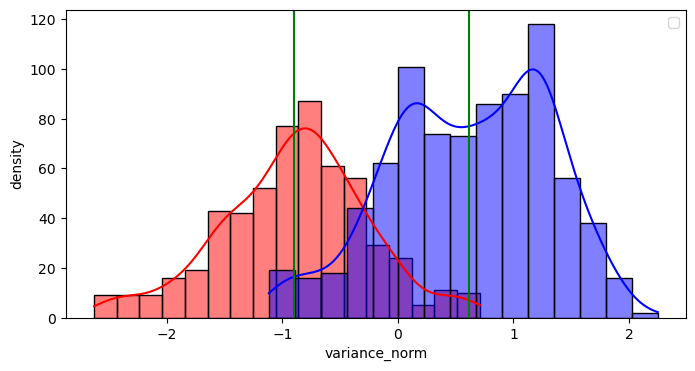

/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

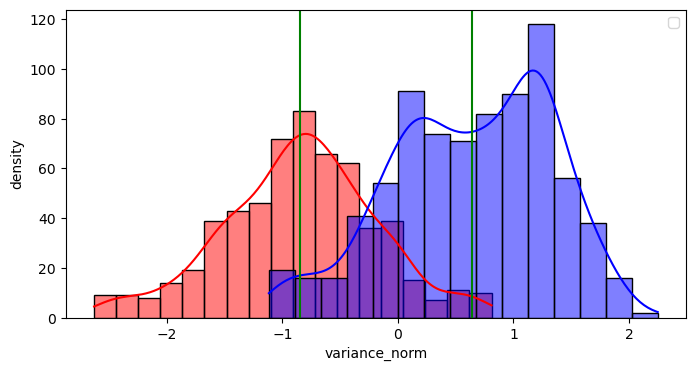

/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

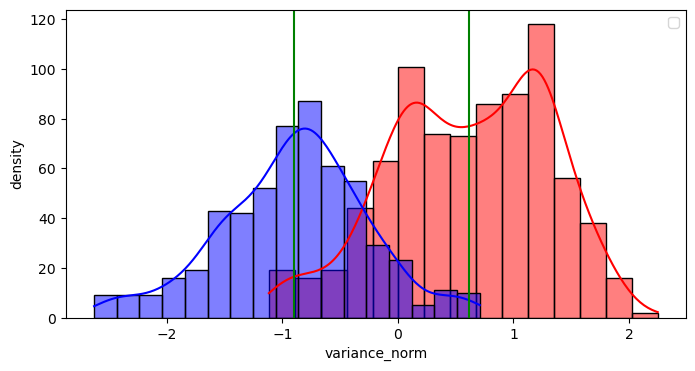

/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

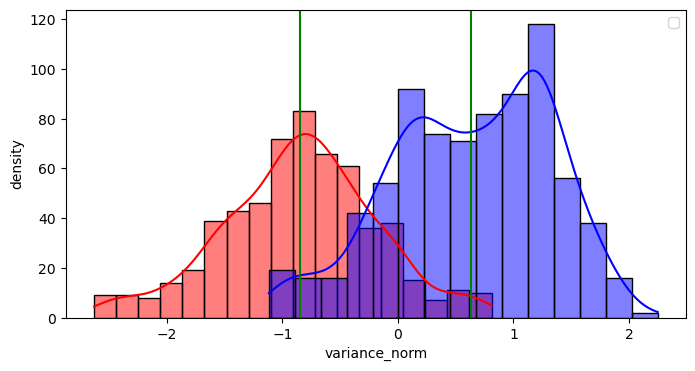

/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

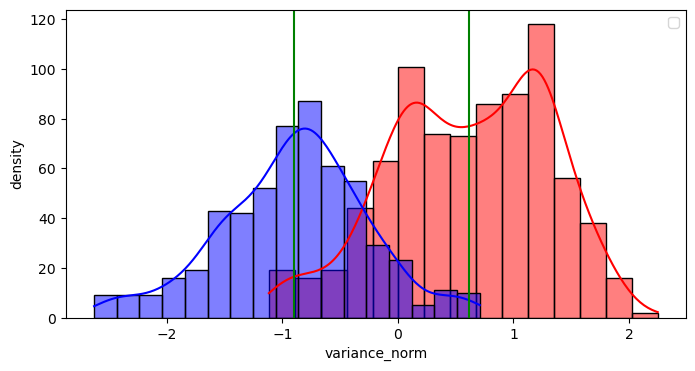

/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

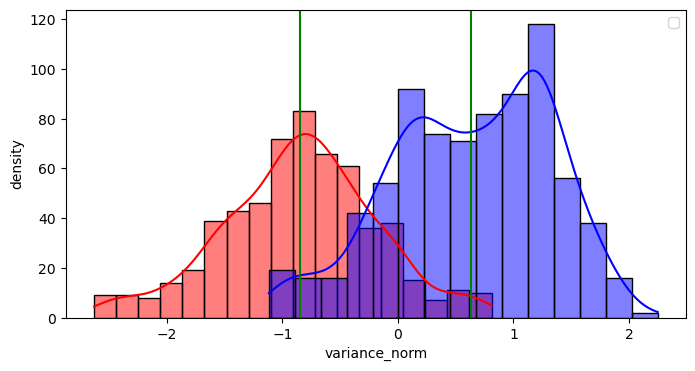

/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

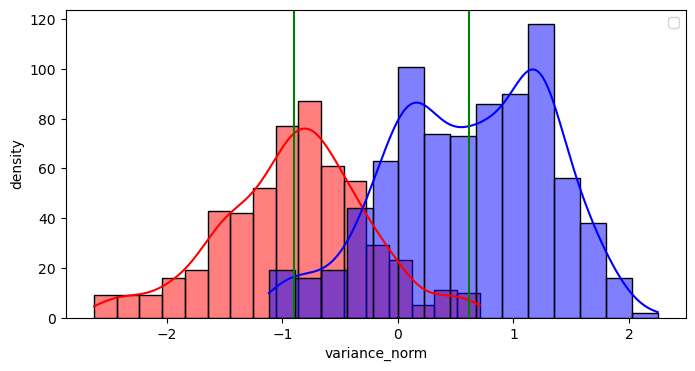

In [187]:
ResultStability(0)

/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

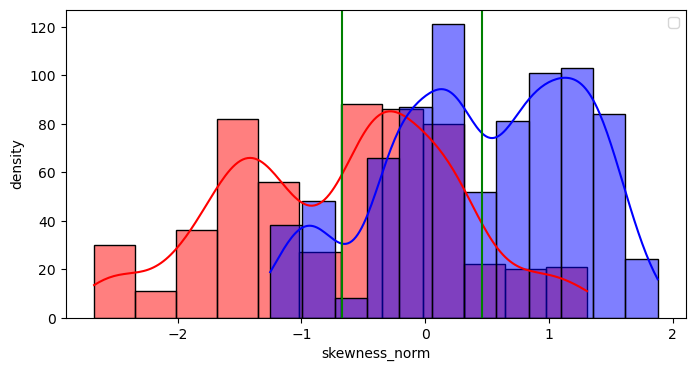

/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

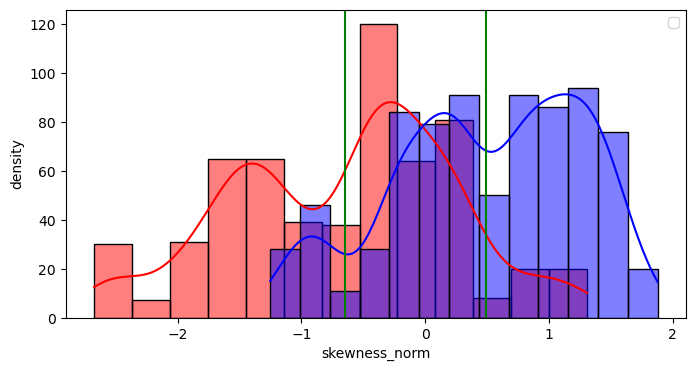

/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

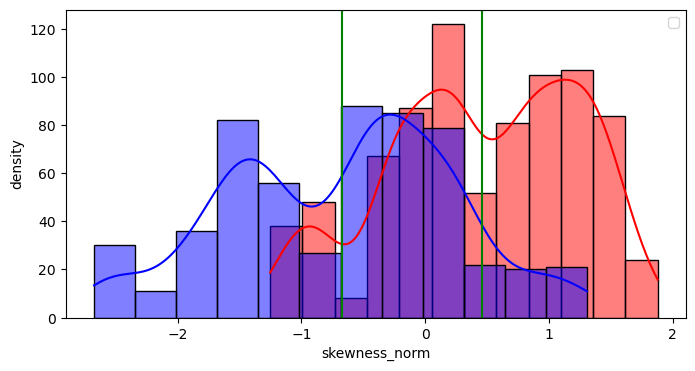

/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

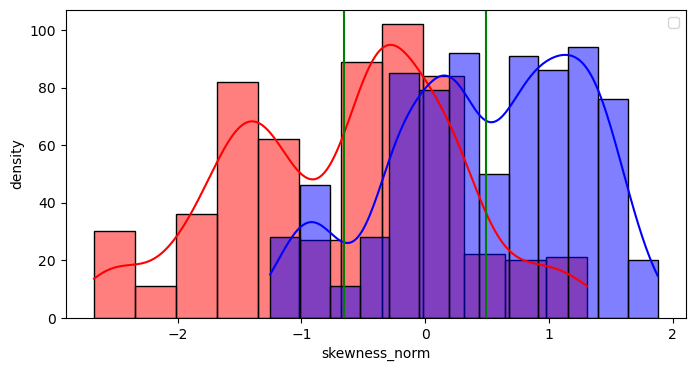

/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

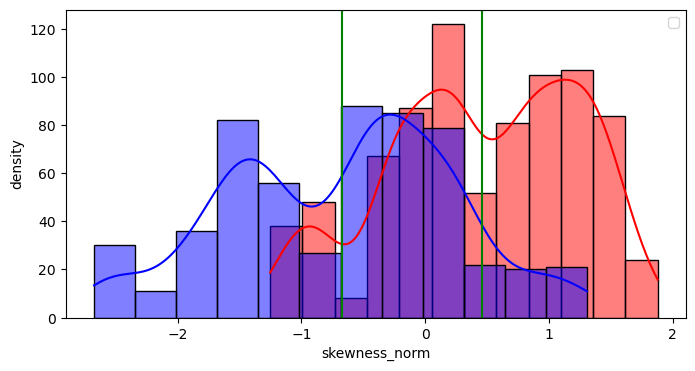

/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

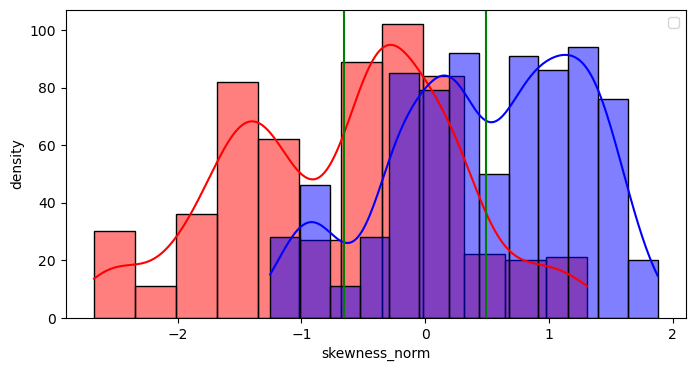

/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

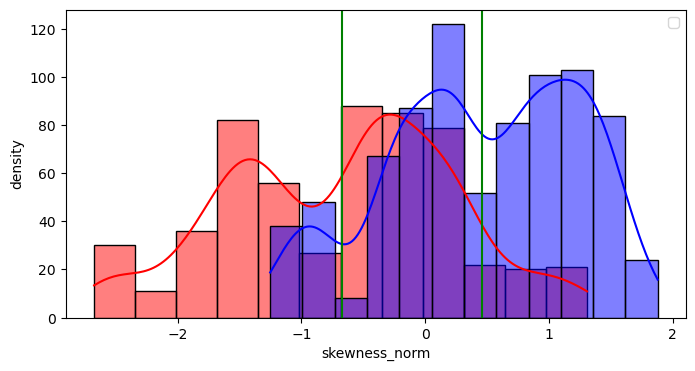

In [188]:
ResultStability(1)

/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

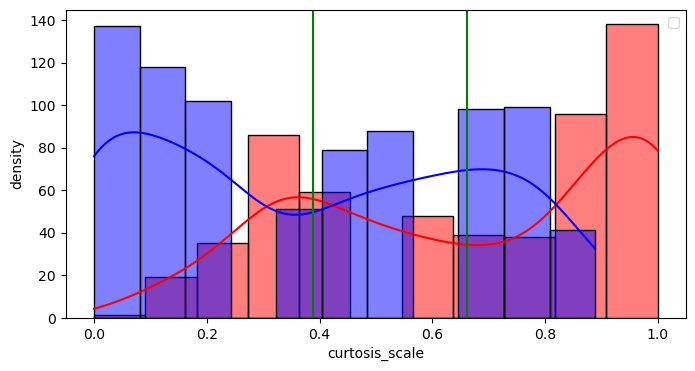

/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

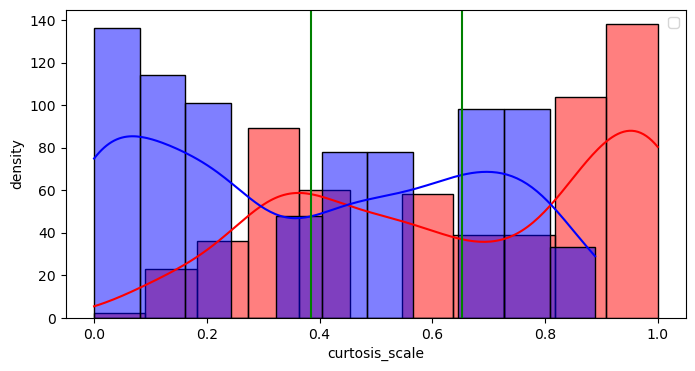

/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

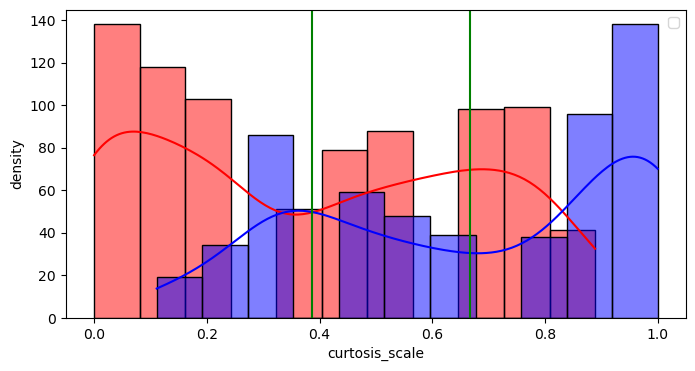

/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

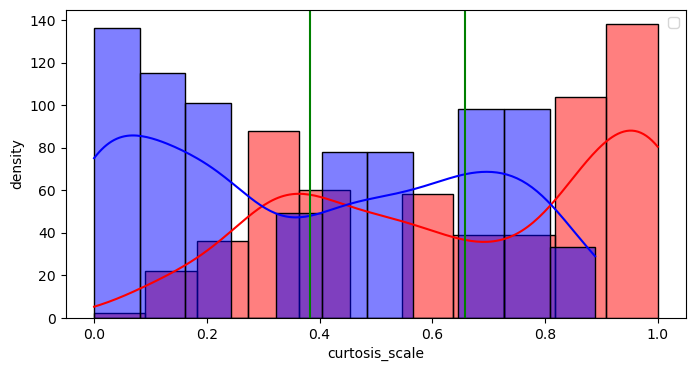

/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

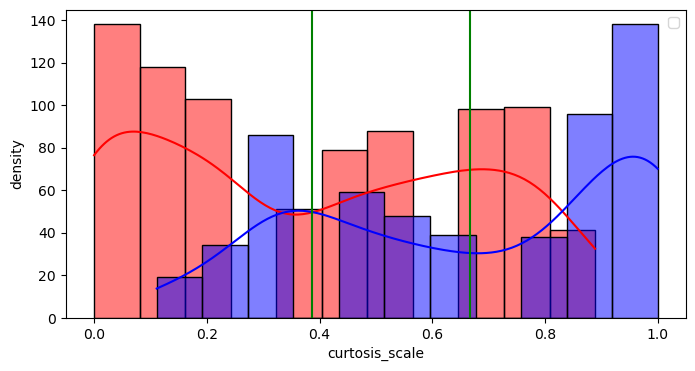

/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

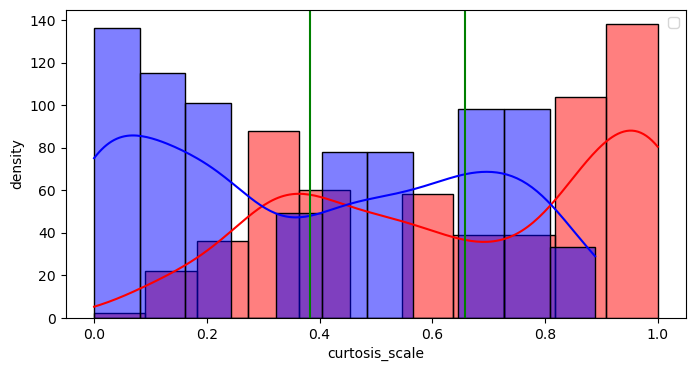

/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

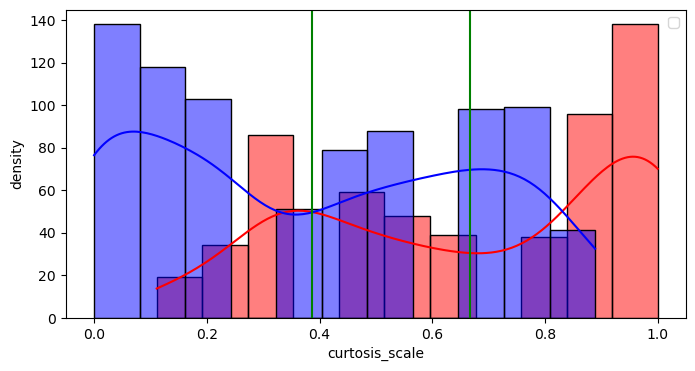

In [189]:
ResultStability(2)

/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

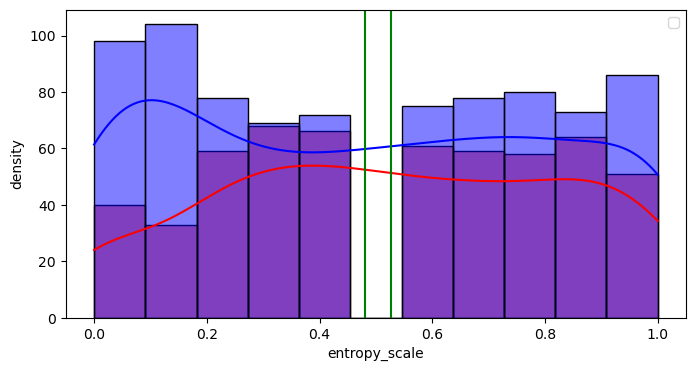

/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

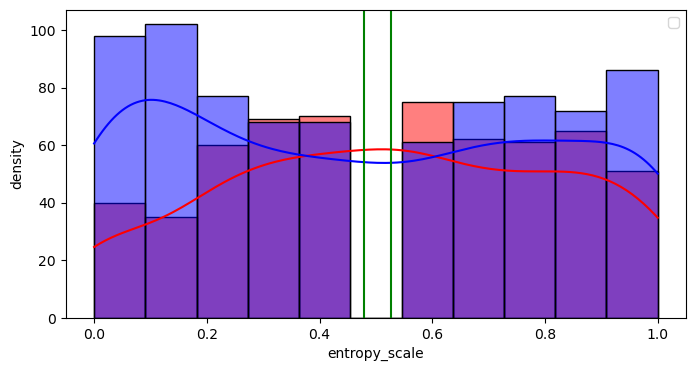

/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

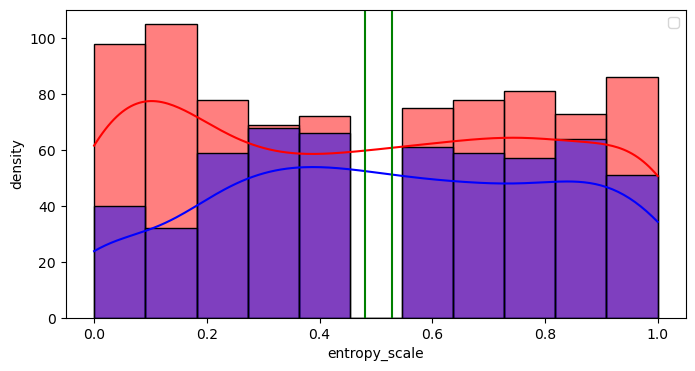

/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

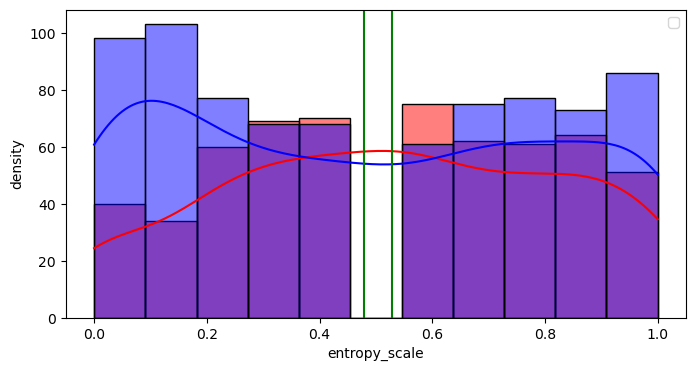

/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

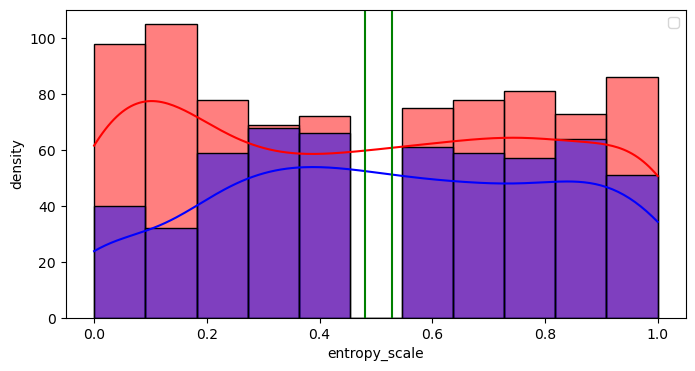

/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

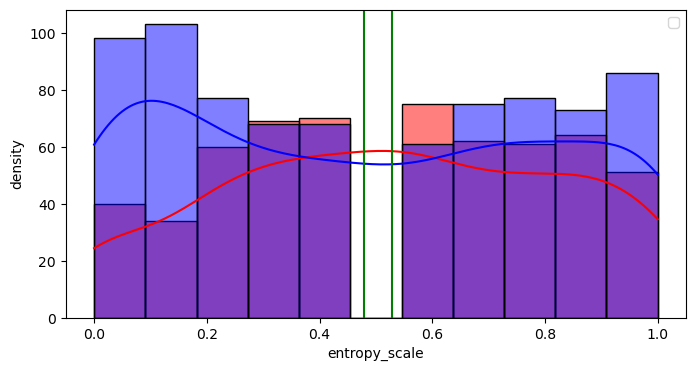

/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/danichao/miniconda3/envs/py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

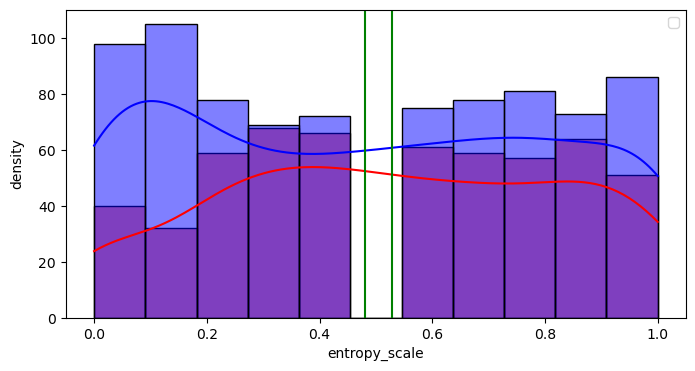

In [190]:
ResultStability(3)

Entropy is almost useless in the classification of true/fake banknotes...

# Evaluate the model

In [39]:
import math

def getSimilarity(row1, row2):
    similarity = data.loc[row1] - data.loc[row2]
    similarity = np.sum((similarity**2.0)/len(data.loc[row1]))
    similarity = 1 - math.sqrt(similarity)
    return similarity

In [192]:
data_results

,variance_norm,skewness_norm,curtosis_scale,entropy_scale,label_1,label_2,label_3,label_4,label_5,label_6,label_7
0,1.121397,1.149036,0.111111,0.555556,1,1,0,1,0,1,1
1,1.446538,1.064065,0.111111,0.333333,1,1,0,1,0,1,1
2,1.207369,-0.777069,0.666667,0.666667,1,1,0,1,0,1,1
3,1.063355,1.295005,0.000000,0.111111,1,1,0,1,0,1,1
4,-0.036758,-1.086642,0.888889,0.444444,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1367,-0.009707,-0.097657,0.222222,0.555556,1,1,0,1,0,1,1
1368,-0.641079,-1.158562,0.888889,0.777778,0,0,1,0,1,0,0
1369,-1.471820,-2.620690,1.000000,0.222222,0,0,1,0,1,0,0
1370,-1.406180,-1.755831,1.000000,0.333333,0,0,1,0,1,0,0


In [193]:
getSimilarity(0,4)

-0.3187934179983345

In [194]:
getSimilarity(0,1367)

0.15649755712784974

In [195]:
getSimilarity(3,4)

-0.39496662377768366

In [196]:
getSimilarity(3,1367)

0.08650623008421687

In [197]:
# Calculate cardinality
card_0 = len(np.where(data_results['label_3'] == 0)[0])
card_1 = len(np.where(data_results['label_3'] == 1)[0])
card = np.array([card_0, card_1])

In [96]:
# Calculate magnitude
def dist_2_centroid(point, centroid):
    dist = np.linalg.norm(point - centroid)

    return dist

In [232]:
centroid = centers[2] # All trials look stable. We choose the third trial, corresponding result is label_3.

In [233]:
mag_0 = \
np.sum(np.sum(((data.loc[data_results['label_3'] == 0, :] - centroids[0])**2.0).values, axis=1)**0.5)

mag_1 = \
np.sum(np.sum(((data.loc[data_results['label_3'] == 1, :] - centroids[1])**2.0).values, axis=1)**0.5)

mag = np.array([mag_0, mag_1])
print(mag)

[1749.21548845 1191.02148919]


<BarContainer object of 2 artists>

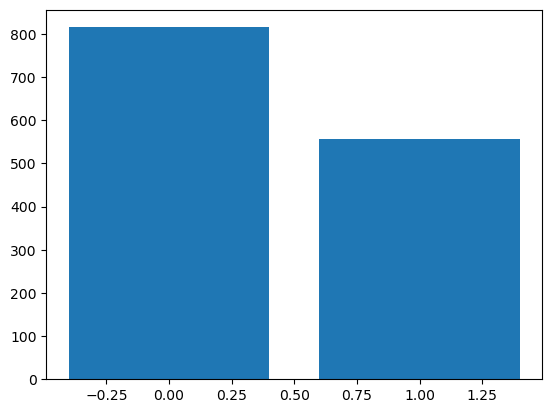

In [234]:
plt.bar([0, 1], card)

<BarContainer object of 2 artists>

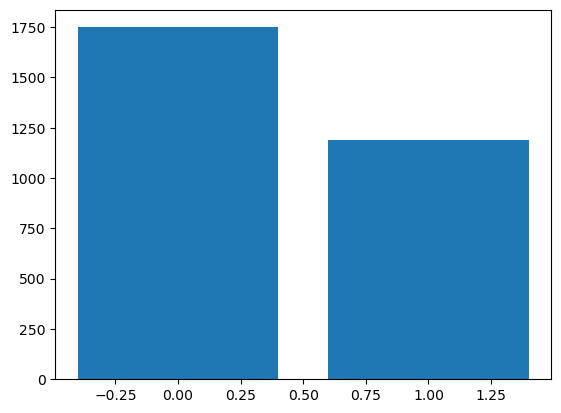

In [235]:
plt.bar([0, 1], mag)

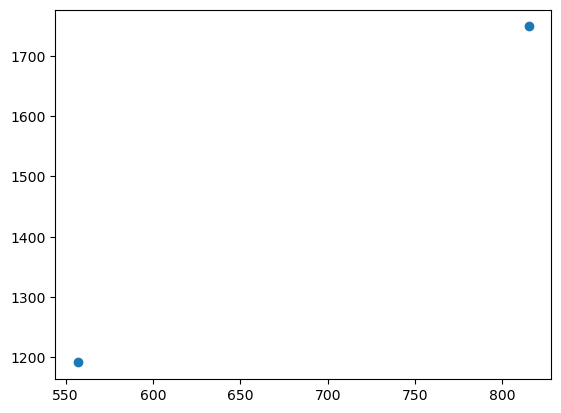

In [236]:
plt.scatter(card, mag)

The cardinality-magnitude metrics look reasonable.

In [49]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, accuracy_score

In [241]:
labels = data_results['label_3'].values

In [262]:
accuracy = accuracy_score(truth, labels)
print('Clustering accuracy:', accuracy)

Clustering accuracy: 0.8651603498542274


In [263]:
recall = recall_score(truth, labels)
print('Clustering recall:', recall)

Clustering recall: 0.8049180327868852


In [264]:
f1 = f1_score(truth, labels)
print('Clustering F1 score:', f1)

Clustering F1 score: 0.8414738646101114


In [244]:
tn, fp, fn, tp = confusion_matrix(truth, labels).ravel()

In [257]:
print('Number of true negatives:', tn)

Number of true negatives: 696


In [256]:
print('Number of true positives:', tp)

Number of true positives: 491


In [258]:
print('Number of false positives:', fp)

Number of false positives: 66


In [259]:
print('Number of false negatives:', fp)

Number of false negatives: 66


### Overall, our classification of true/fake banknotes without ground truths is not bad, mainly due to our careful procedure preprocessing the four features with normalization and scaling.